# Play Atari games with DQN

This notebook shows how to play image based Atari games (will leave out the RAM games since the pipeline can be very different) with DQN agents.

In [1]:
%matplotlib inline
import os
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

In [2]:
class Qnet(Model):
    def __init__(self, action_space_size, state_shape):
        super(Qnet, self).__init__()
        self.action_space_size = action_space_size
        self.state_shape = state_shape
        # Define conv layers
        self.conv_in = Conv2D(32, 8, strides=4, activation='relu', input_shape=self.state_shape)
        self.conv_0 = Conv2D(64, 4, strides=2, activation='relu')
        self.conv_1 = Conv2D(64, 3, strides=1, activation='relu')
        self.flatten = Flatten()
        # Dense layers
        self.dense_0 = Dense(512, activation='relu')
        self.dense_out = Dense(self.action_space_size, activation='linear')
    
    def call(self, inputs):
        x = inputs
        x = self.conv_in(x)
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.flatten(x)
        x = self.dense_0(x)
        x = self.dense_out(x)
        return x

In [11]:
class ReplayBuffer:
    def __init__(self, max_length, state_shape, action_space_size):
        self.max_length = max_length
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.state_spec = tf.TensorSpec(state_shape, dtype=tf.float32, name='state')
        self.q_vals_spec = tf.TensorSpec([self.action_space_size], dtype=tf.float32, name='q_vals')
        self.buffer = TFUniformReplayBuffer(
            data_spec=(self.state_spec, self.q_vals_spec),
            batch_size=1,
            max_length=self.max_length)
    
    def get_size(self):
        return int(self.buffer.num_frames())
    
    def add_batch(self, batch):
        self.buffer.add_batch(batch)
    
    def get_dataset(self, sample_batch_size, num_steps):
        return self.buffer.as_dataset(sample_batch_size=sample_batch_size, num_steps=num_steps)

In [4]:
class DqnAgent:    
    def __init__(self, action_space_size, state_shape, train_per_eps,
                 learning_rate, checkpoint_location, update_interval):
        self.action_space_size = action_space_size
        self.state_shape = state_shape
        self.update_interval = update_interval
        self.batch_cnt = 0
        self.learning_rate = learning_rate
        self.train_per_eps = train_per_eps
        self.checkpoint_location = checkpoint_location
        self.q_net = self.create_q_net()
        self.target_q_net = self.create_q_net()
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(1), net=self.q_net)
        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_location, max_to_keep=3)
        try:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            self.update()
        except:
            self.q_net = self.create_q_net()
            print('Checkpoint not found, initialize new model')
        
    def update(self):
        self.target_q_net.set_weights(self.q_net.get_weights())
        
    def create_q_net(self):
        q_net = Qnet(self.action_space_size, self.state_shape)
        # q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate), loss=tf.keras.losses.Huber())
        # q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        q_net.compile(optimizer=tf.optimizers.RMSprop(learning_rate=self.learning_rate), loss='mse')
        return q_net
    
    def random_policy(self, state):
        return np.random.randint(self.action_space_size)
    
    def net_policy(self, state):
        q_vals = self.get_q_vals(state).numpy()[0]
        action = np.argmax(q_vals)
        return action
    
    def collect_policy(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.random_policy(state)
        return self.net_policy(state)
    
    def get_next_q_vals(self, state):
        next_q_vals = self.target_q_net(tf.convert_to_tensor([state], dtype=tf.float32))
        return next_q_vals
    
    def get_q_vals(self, state):
        q_vals = self.q_net(tf.convert_to_tensor([state], dtype=tf.float32))
        return q_vals
    
    def train(self, replay_buffer, batch_size):
        loss = []
        dataset = replay_buffer.get_dataset(batch_size, self.train_per_eps)
        iterator = iter(dataset)
        for i in range(self.train_per_eps):
            batch, _ = next(iterator)
            states, target_q_vals = batch
            result = self.q_net.fit(x=states, y=target_q_vals, verbose=0)
            loss.append(result.history['loss'])
            self.batch_cnt += 1
            if self.batch_cnt % self.update_interval == 0:
                print('Finished {0} ({1}%). Update target net.'.format(i, i / self.train_per_eps * 100.0))
                self.update()
        self.checkpoint_manager.save()
        return loss

In [5]:
class GameEnv:
    def __init__(self, game_id, n_frames, max_noop_steps):
        self.game_id = game_id
        self.n_frames = n_frames
        self.max_noop_steps = max_noop_steps
        self.env = gym.make(game_id)
        self.frames = deque(maxlen=self.n_frames)
        self.init_state = None
        self.still_doing_nothing = True
        self.current_step = 0
        
    def sanitize_state(self, state, downsample=2):
        img = Image.fromarray(state).convert('L')
        w, h = img.size
        w, h = w // 2, h // 2
        img = np.array(img.resize((w, h)))
        normalized_img = img / 255.0
        return normalized_img
    
    def normalize_reward(self, reward):
        if reward > 0:
            return 1.0
        elif reward < 0:
            return -1.0
        else:
            return 0.0
        
    def get_action_space_size(self):
        return self.env.action_space.n
    
    def get_state_shape(self):
        initial_state = self.reset()
        return initial_state.shape
        
    def render(self):
        self.env.render()
        
    def get_frames(self):
        frames = np.array(self.frames)
        frames = np.swapaxes(frames, 0, 2)
        return frames
    
    def doing_noting(self, state):
        if self.current_step == self.max_noop_steps:
            return self.still_doing_nothing
        elif self.current_step < self.max_noop_steps:
            if self.still_doing_nothing and not np.array_equal(np.array(state), self.init_state):
                self.still_doing_nothing = False
        else:
            return False
        
    def reset(self):
        unsanitized_initial_state = self.env.reset()
        self.init_state = np.array(unsanitized_initial_state)
        self.current_step = 0
        self.still_doing_nothing = True
        initial_state = self.sanitize_state(unsanitized_initial_state)
        for _ in range(self.n_frames):
            self.frames.append(initial_state)
        return self.get_frames()
    
    def step(self, action):
        unsanitized_state, unnormalized_reward, done, info = self.env.step(action)
        if self.doing_noting(unsanitized_state):
            done = True
        state = self.sanitize_state(unsanitized_state)
        self.frames.append(state)
        reward = self.normalize_reward(unnormalized_reward)
        self.current_step += 1
        return self.get_frames(), reward, done, info
    
    def close(self):
        self.env.close()

In [6]:
def play_episode(env, agent, epsilon, epsilon_decay_per_step, final_epsilon, gamma, collect, buffer, render):
    state = env.reset()
    done = False
    steps = 0
    total_reward = 0.0
    current_epsilon = epsilon
    while not done:
        if render:
            env.render()
        action = agent.collect_policy(state, epsilon)
        next_state, reward, done, info = env.step(action)
        if collect:
            q_vals = agent.get_q_vals(state).numpy()[0]
            next_q_vals = agent.get_next_q_vals(next_state).numpy()[0]
            q_vals[action] = reward
            if not done:
                q_vals[action] += (next_q_vals.max() * gamma)
            buffer.add_batch((
                tf.convert_to_tensor([state], dtype=tf.float32),
                tf.convert_to_tensor([q_vals], dtype=tf.float32)
            ))
            if current_epsilon >= final_epsilon:
                current_epsilon -= epsilon_decay_per_step
        state = next_state
        total_reward += reward
        steps += 1
    return total_reward, current_epsilon

In [7]:
def init_tensorflow_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
    print('GPU initialized')

In [8]:
def visualize_training_result(loss, train_rewards, eval_rewards, epsilon, eps):
    fig, (loss_plt, train_plt, eval_plt) = plt.subplots(3, figsize=(20, 8))
    fig.suptitle('Eps {0} with epsilon {1}'.format(eps, epsilon))
    loss_plt.plot(loss)
    loss_plt.set_title('Loss history')
    train_plt.plot(train_rewards)
    train_plt.set_title('Training reward history')
    eval_plt.plot(eval_rewards)
    eval_plt.set_title('Eval reward history')
    plt.show()

In [9]:
def train_agent(max_eps=200,
                max_steps_increase_amount=10,
                max_steps_increase_interval=5,
                render=False,
                max_buffer_len=1000000,
                start_buffer_len=50000,
                max_noop_steps=30,
                batch_size=128,
                visualize_interval=1,
                train_per_eps=50000,
                learning_rate=0.00025,
                initial_epsilon=1.0,
                final_epsilon=0.1,
                epsilon_decay_interval=1000000,
                update_interval=10000,
                eval_interval=1,
                eval_eps=5,
                agent_id='default', train_eps=5,
                initial_save_threshold=0.0,
                game_id='Breakout-v0'):
    init_tensorflow_gpu()
    train_env = GameEnv(game_id, 4, max_noop_steps)
    eval_env = GameEnv(game_id, 4, max_noop_steps)
    state_shape = train_env.get_state_shape()
    action_space_size = train_env.get_action_space_size()
    epsilon = initial_epsilon
    buf = ReplayBuffer(max_buffer_len, state_shape, action_space_size)
    print('Initialize agent with state shape {0} and action space size {1}'.format(state_shape, action_space_size))
    agent = DqnAgent(action_space_size, state_shape,
                     train_per_eps, learning_rate,
                     os.path.join('./checkpoints', agent_id),
                     update_interval)
    loss = []
    train_rewards = [0.0]
    eval_rewards = [0.0]
    best_eval_reward = initial_save_threshold
    init_buf_steps = 0
    epsilon_decay_per_step = (initial_epsilon - final_epsilon) / epsilon_decay_interval
    while buf.get_size() < start_buffer_len:
        train_reward, epsilon = play_episode(
            train_env, agent, render=render,
            collect=True, buffer=buf, epsilon=epsilon, gamma=0.95,
            epsilon_decay_per_step=epsilon_decay_per_step,
            final_epsilon=final_epsilon
        )
        train_rewards.append(train_reward)
        print('Currently filled {0} ({1}%) buffer'.format(buf.get_size(), buf.get_size() / start_buffer_len * 100.0))
        init_buf_steps += 1
    print('Buffer has been filled with {0} episodes.'.format(init_buf_steps))
    for eps in range(1, max_eps + 1):
        for _ in range(train_eps):
            train_reward, epsilon = play_episode(
                train_env, agent, render=render,
                collect=True, buffer=buf, epsilon=epsilon, gamma=0.95,
                epsilon_decay_per_step=epsilon_decay_per_step,
                final_epsilon=final_epsilon
            )
            train_rewards.append(train_reward)
        loss += agent.train(buf, batch_size)
        if eps % eval_interval == 0:
            total_reward = 0.0
            for _ in range(eval_eps):
                eval_reward, _ = play_episode(
                    eval_env, agent, render=render,
                    collect=False, epsilon=0, epsilon_decay_per_step=0,
                    final_epsilon=0, buffer=None, gamma=0
                )
                total_reward += eval_reward
            avg_reward = total_reward/eval_eps
            eval_rewards.append(avg_reward)
            if avg_reward >= best_eval_reward:
                best_eval_reward = avg_reward
                tf.saved_model.save(agent.q_net, os.path.join('./models', agent_id))
        if eps % visualize_interval == 0:
            visualize_training_result(loss, train_rewards, eval_rewards, epsilon, eps)
    print('Last saved model has eval result {0}'.format(best_eval_reward))
    train_env.close()
    eval_env.close()
    print('Done')

1 Physical GPUs, 1 Logical GPUs
GPU initialized
Initialize agent with state shape (80, 105, 4) and action space size 4
Currently filled 244 (0.488%) buffer
Currently filled 422 (0.844%) buffer
Currently filled 662 (1.324%) buffer
Currently filled 940 (1.8800000000000001%) buffer
Currently filled 1099 (2.198%) buffer
Currently filled 1312 (2.624%) buffer
Currently filled 1519 (3.0380000000000003%) buffer
Currently filled 1763 (3.526%) buffer
Currently filled 2013 (4.026%) buffer
Currently filled 2319 (4.638%) buffer
Currently filled 2529 (5.058%) buffer
Currently filled 2831 (5.662%) buffer
Currently filled 3013 (6.026%) buffer
Currently filled 3202 (6.404%) buffer
Currently filled 3470 (6.94%) buffer
Currently filled 3704 (7.4079999999999995%) buffer
Currently filled 3878 (7.756%) buffer
Currently filled 4214 (8.427999999999999%) buffer
Currently filled 4534 (9.068%) buffer
Currently filled 4713 (9.426%) buffer
Currently filled 4962 (9.924%) buffer
Currently filled 5227 (10.45399999999

Currently filled 47550 (95.1%) buffer
Currently filled 47816 (95.63199999999999%) buffer
Currently filled 48087 (96.174%) buffer
Currently filled 48264 (96.528%) buffer
Currently filled 48444 (96.88799999999999%) buffer
Currently filled 48678 (97.356%) buffer
Currently filled 48865 (97.72999999999999%) buffer
Currently filled 49104 (98.208%) buffer
Currently filled 49306 (98.612%) buffer
Currently filled 49580 (99.16%) buffer
Currently filled 49794 (99.588%) buffer
Currently filled 49968 (99.936%) buffer
Currently filled 50130 (100.25999999999999%) buffer
Buffer has been filled with 202 episodes.
Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property sh

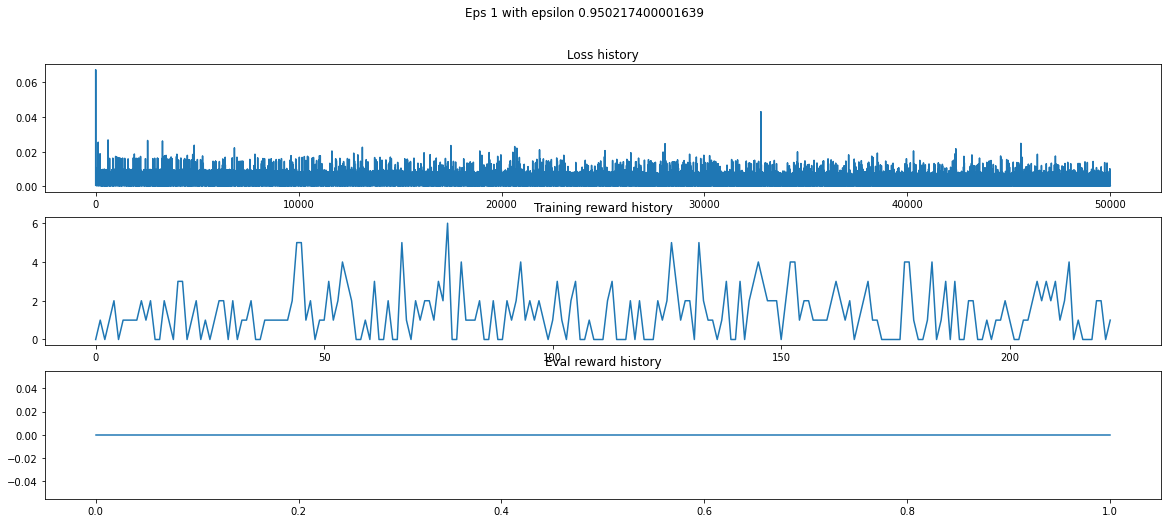

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
INFO:tensorflow:Assets written to: ./models\default\assets


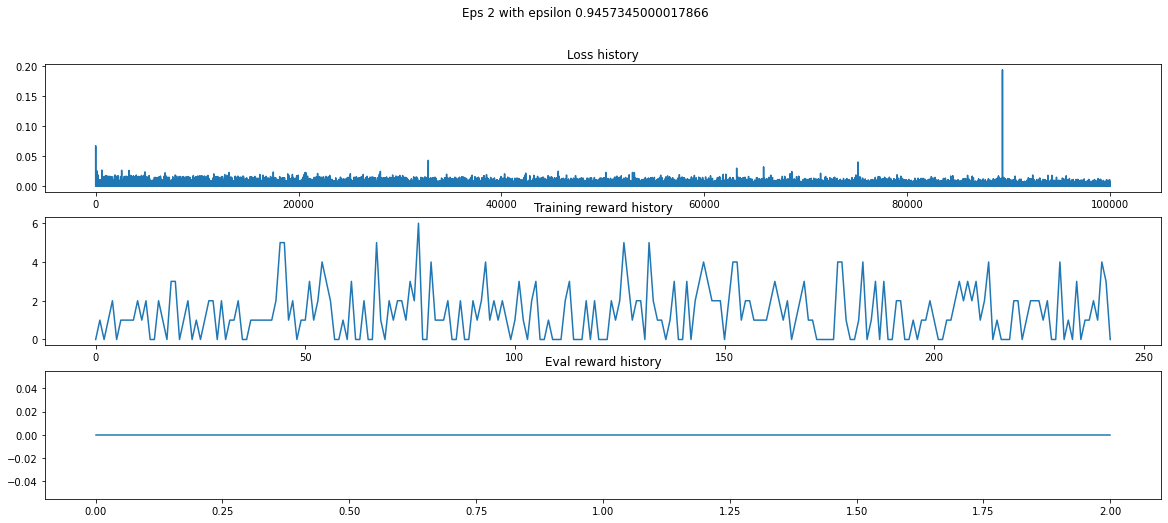

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
INFO:tensorflow:Assets written to: ./models\default\assets


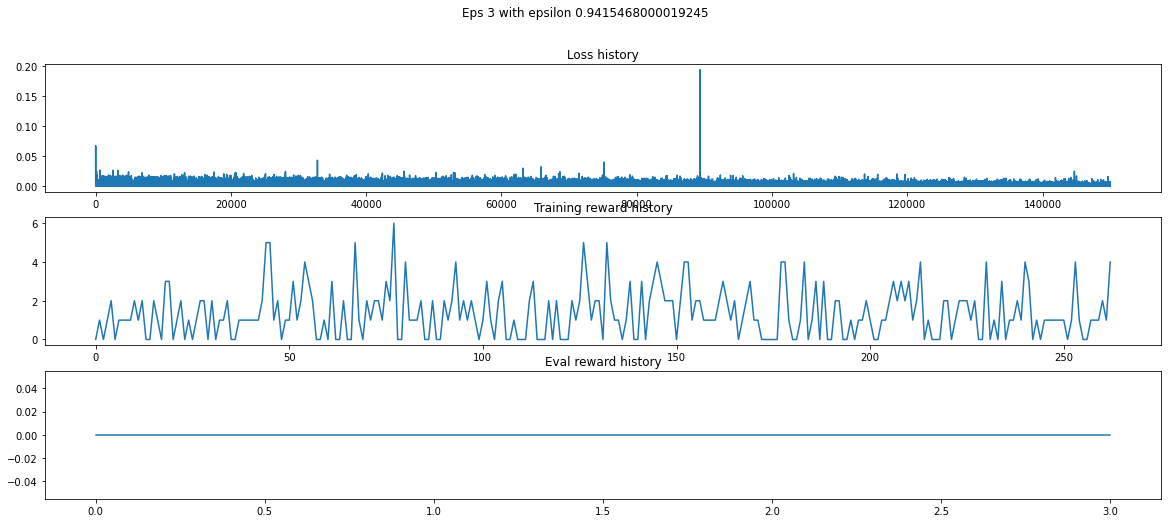

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
INFO:tensorflow:Assets written to: ./models\default\assets


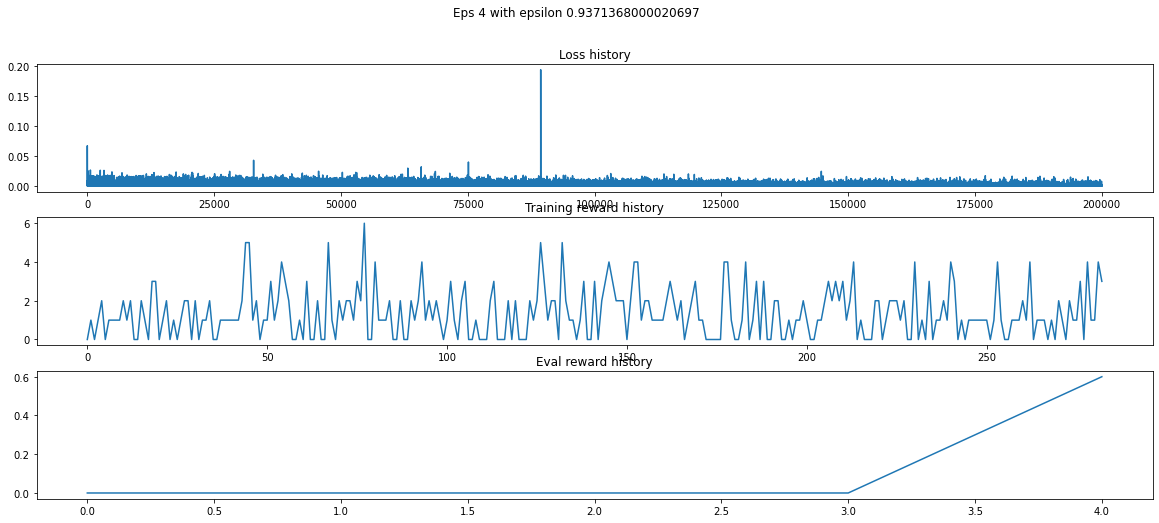

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


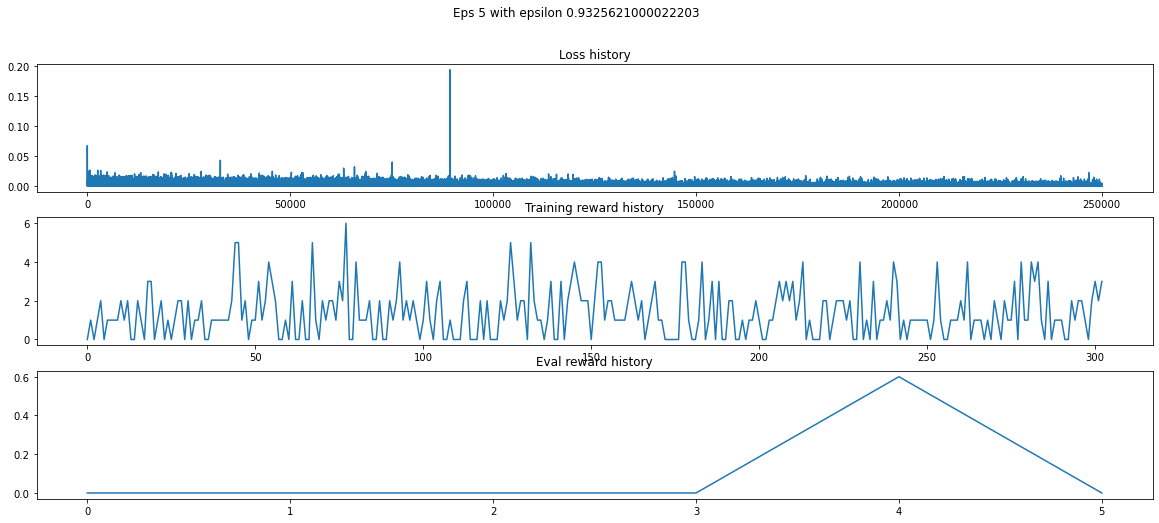

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


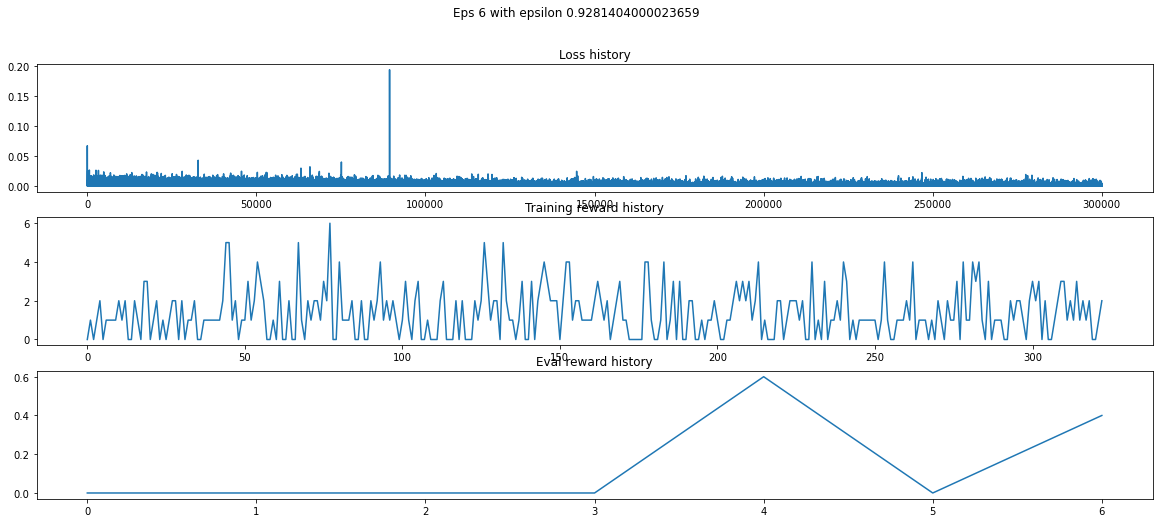

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


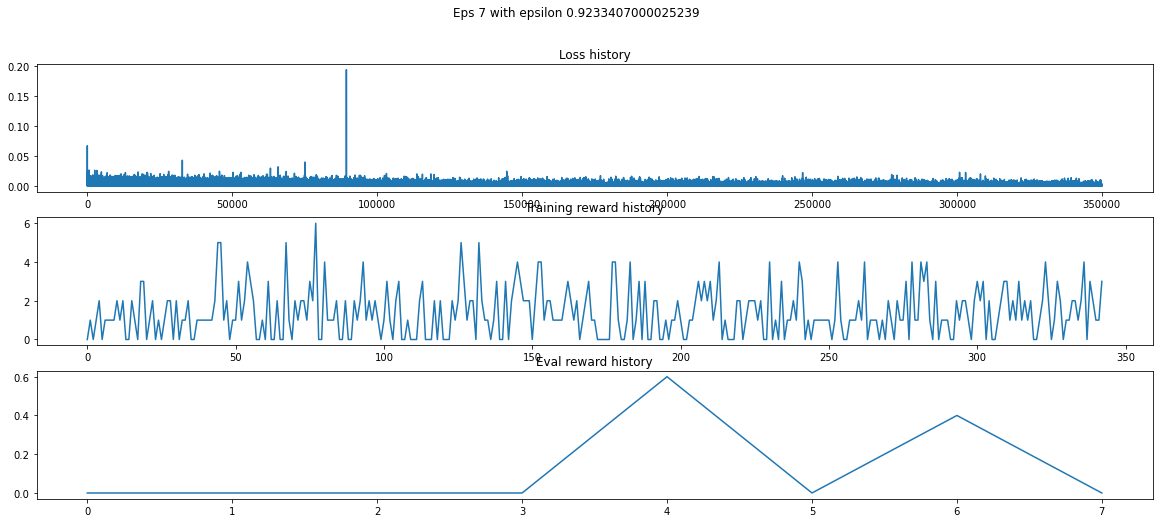

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
INFO:tensorflow:Assets written to: ./models\default\assets


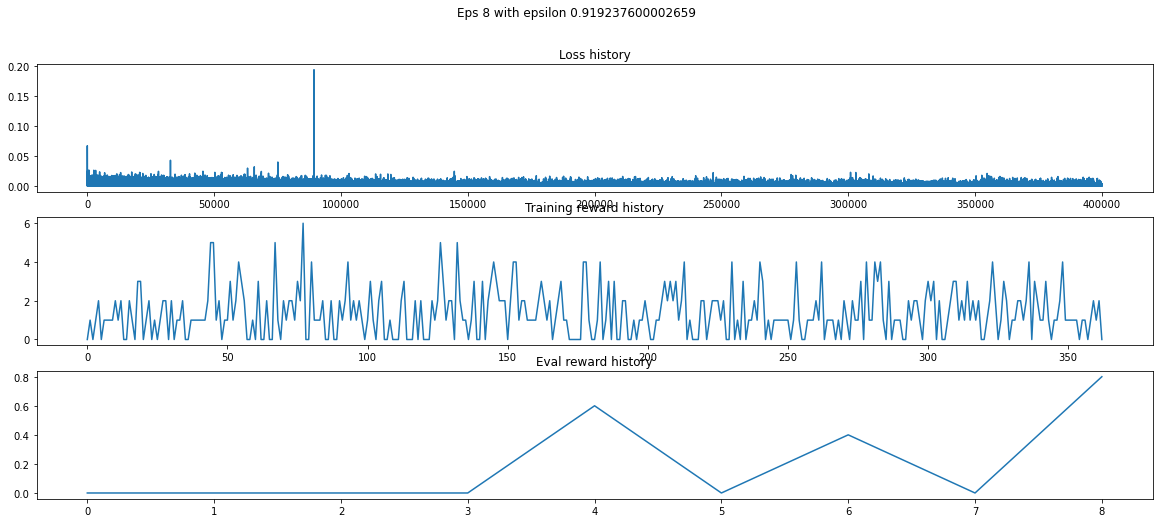

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.
INFO:tensorflow:Assets written to: ./models\default\assets


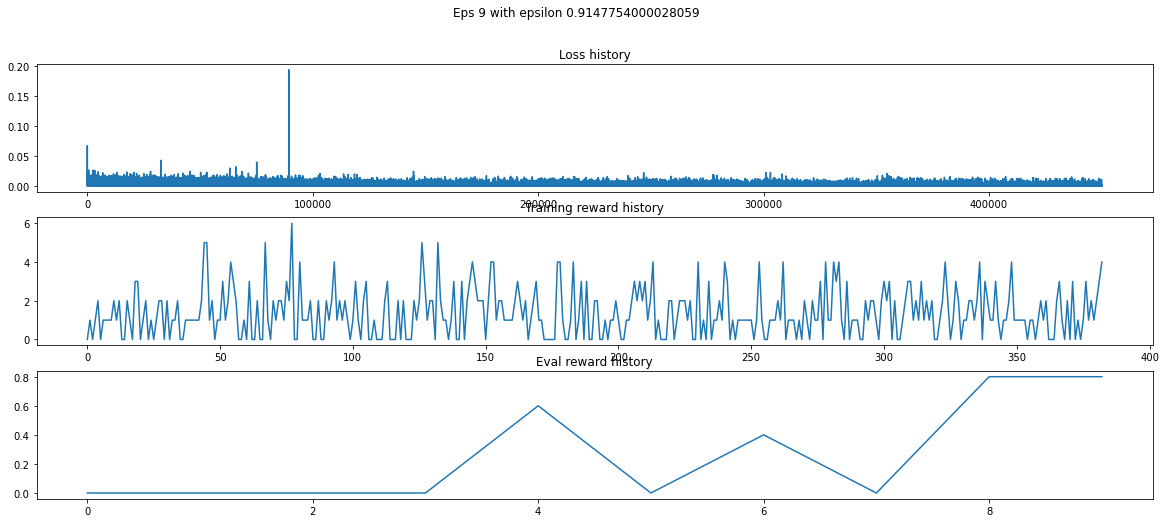

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


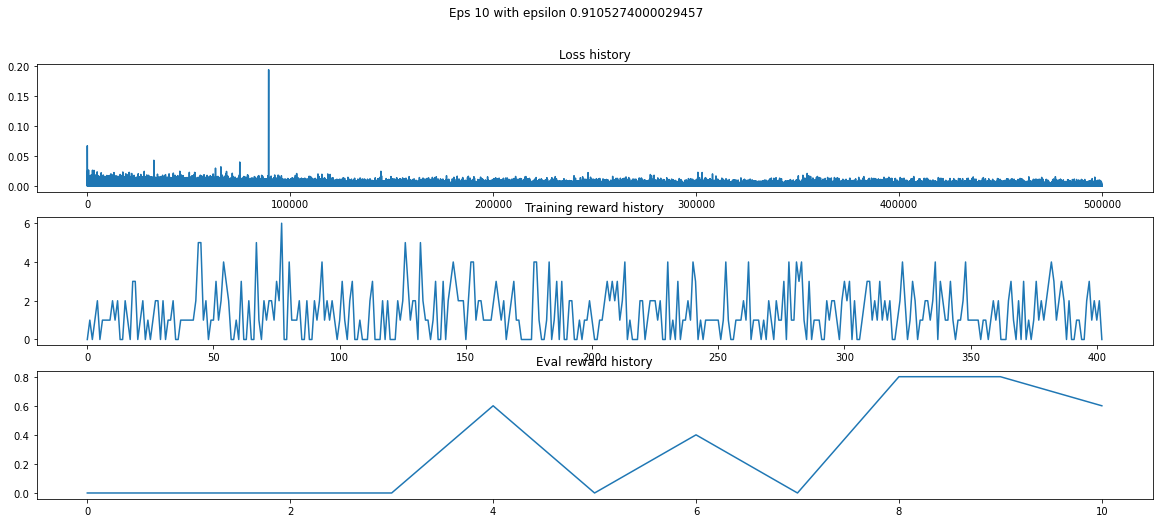

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


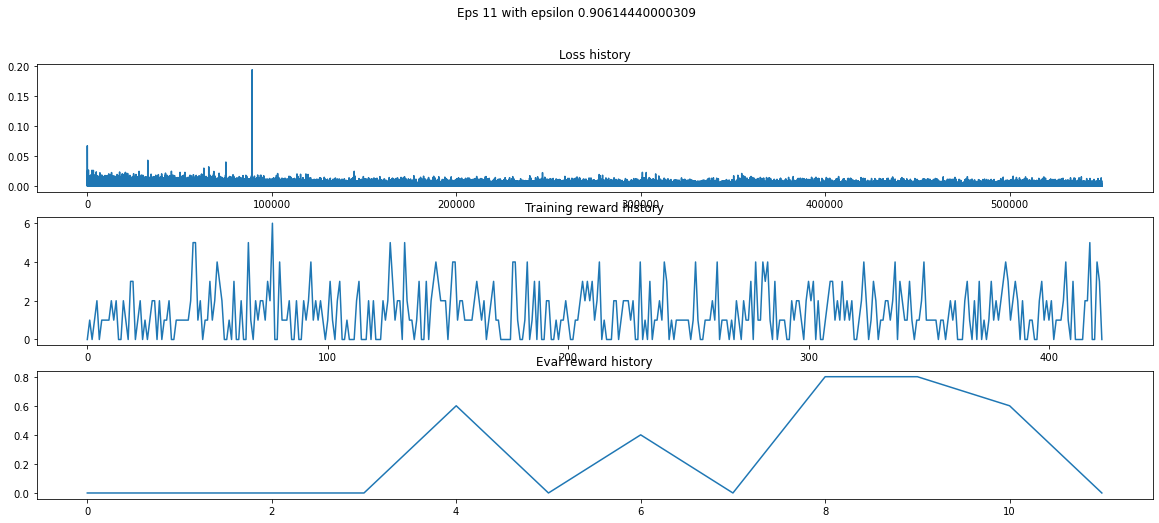

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


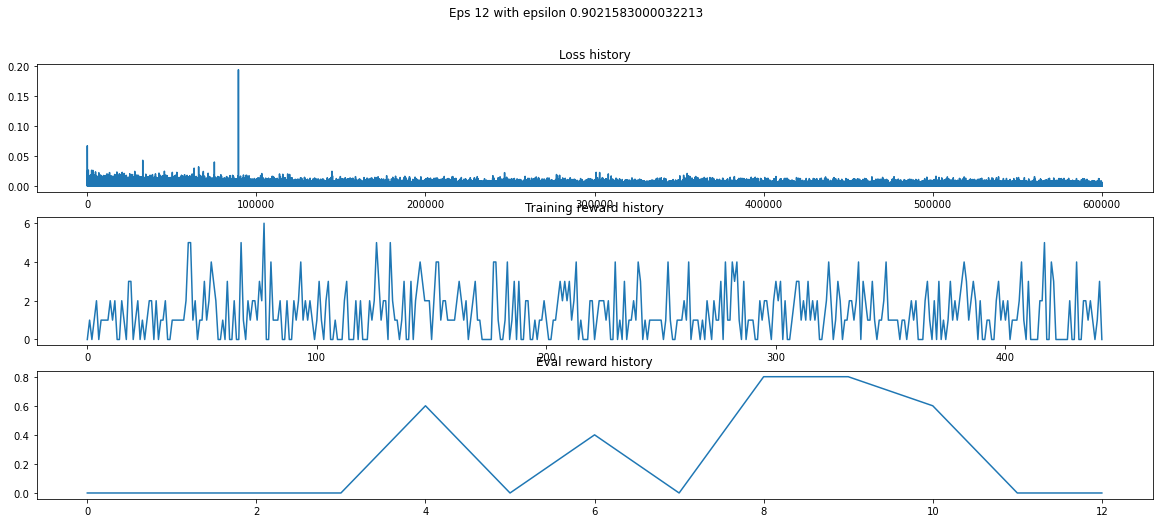

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


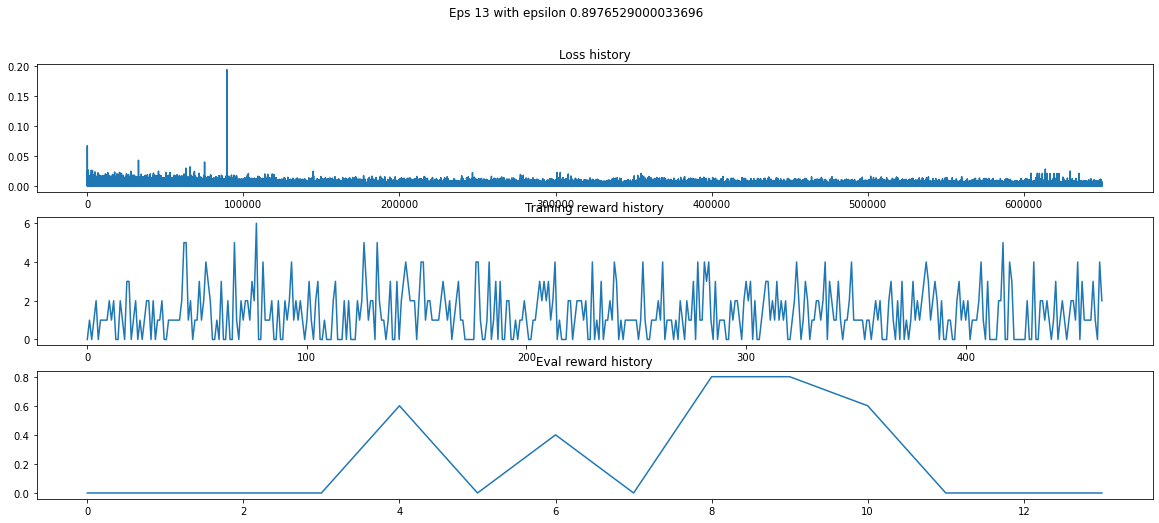

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


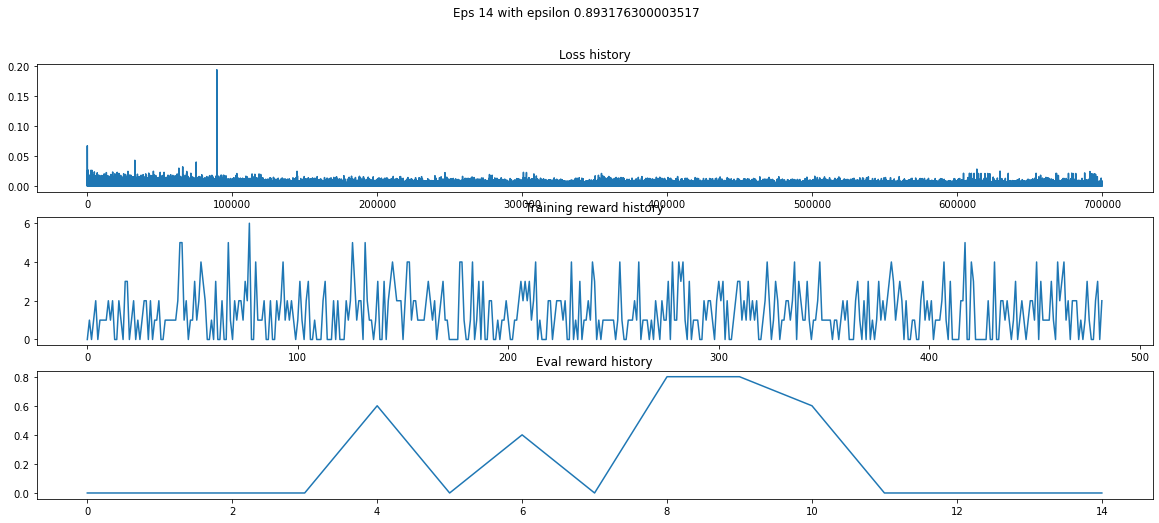

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


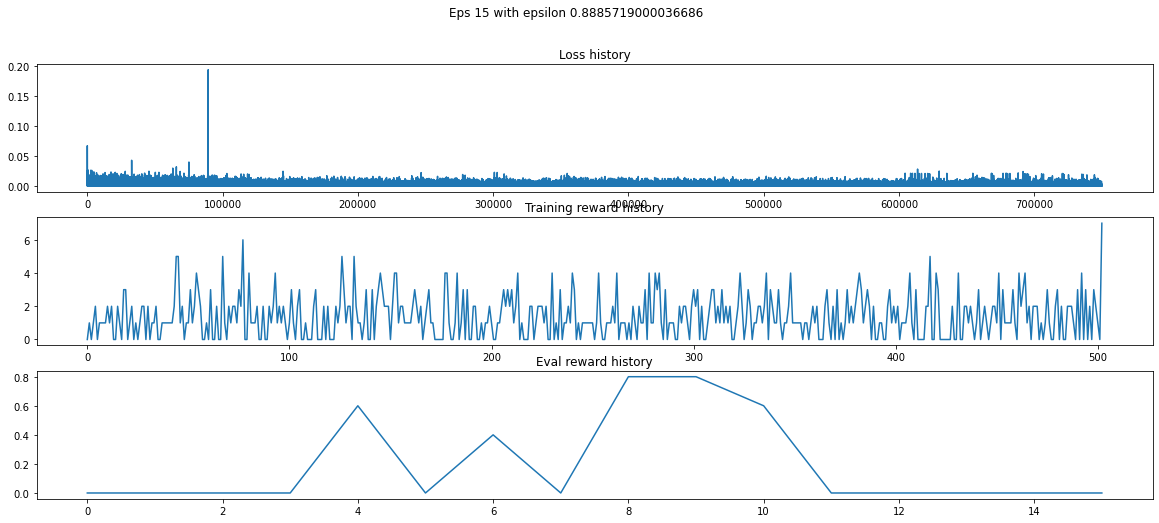

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


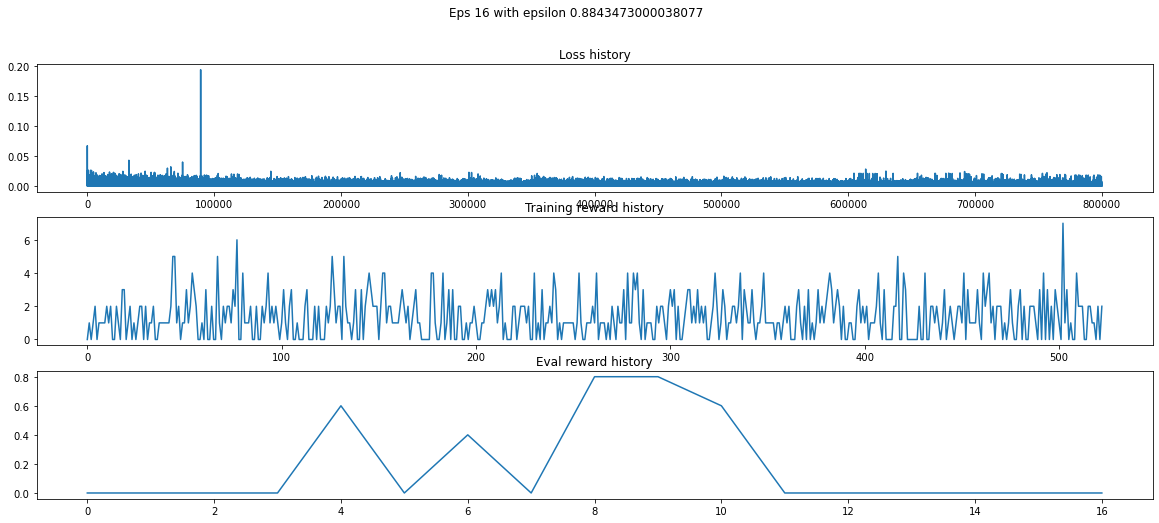

Finished 9999 (19.997999999999998%). Update target net.
Finished 19999 (39.998%). Update target net.
Finished 29999 (59.998%). Update target net.
Finished 39999 (79.998%). Update target net.
Finished 49999 (99.998%). Update target net.


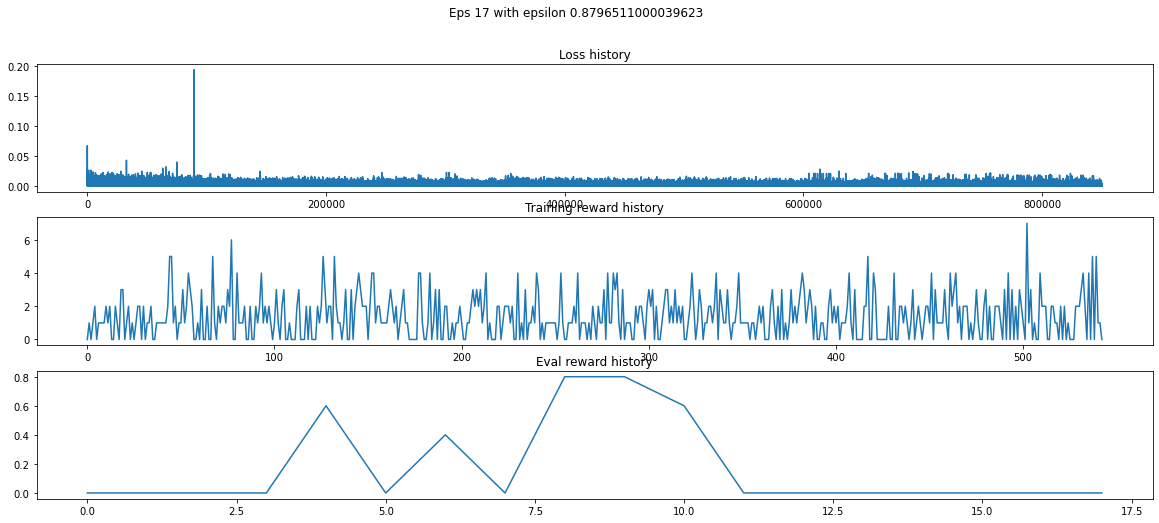

Finished 9999 (19.997999999999998%). Update target net.


In [ ]:
train_agent(
    game_id='Breakout-v0',
    max_eps=2000,
    render=False,
    batch_size=32,
    train_eps=20,
    # In the paper this is 50000
    train_per_eps=50000,
    max_buffer_len=500000,
    # In the paper this is 50000
    start_buffer_len=50000,
    eval_eps=5)